In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/ExpW/data/image"

ls: cannot access '/content/drive/MyDrive/Colab Notebooks/ExpW/data/image': No such file or directory


In [ ]:
!7za -y x "/content/drive/MyDrive/Colab Notebooks/ExpW/data/image"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/Colab Notebooks/ExpW/data/                                                           1 folder, 8 files, 8113576419 bytes (7738 MiB)
  0%    
Extracting archive: /content/drive/MyDrive/Colab Notebooks/ExpW/data/image/origin.7z.001
--
Path = /content/drive/MyDrive/Colab Notebooks/ExpW/data/image/origin.7z.001
Type = Split
Physical Size = 1048576000
Volumes = 8
Total Physical Size = 8113576419
----
Path = origin.7z
Size = 8113576419
--
Path = origin.7z
Type = 7z
Physical Size = 8113576419
Headers Size = 863607
Method = LZMA:25
Solid = +
Blocks = 2

  0%      0% - origin/afraid_African_214.jpg

In [ ]:
!cp -r ./origin "/content/drive/MyDrive/Colab Notebooks/origin.7z*"

In [ ]:
label_file_path=r"/content/drive/MyDrive/Colab Notebooks/ExpW/data/label/label.lst"
images_folder_path=r"/content/drive/MyDrive/Colab Notebooks/origin.7z*"

In [ ]:
import os
len(os.listdir("/content/drive/MyDrive/Colab Notebooks/ExpW/data/image"))


8

In [ ]:
import pandas as pd
df_info=pd.read_csv(label_file_path, sep=" ",header=None)
df_info.columns=['image_name','face_id_in_image','face_box_top','face_box_left','face_box_right','face_box_bottom','face_box_cofidence','expression_label']
df_info.head()


image_name  face_id_in_image  face_box_top  face_box_left  \
0  angry_actor_104.jpg                 0            28            113   
1  angry_actor_109.jpg                 0            31            157   
2  angry_actor_120.jpg                 1            53             53   
3   angry_actor_13.jpg                 0            77             51   
4  angry_actor_132.jpg                 0            95             31   

   face_box_right  face_box_bottom  face_box_cofidence  expression_label  
0             226              141             22.9362                 0  
1             345              219             50.3056                 0  
2             372              372             13.9434                 2  
3             362              388             85.8104                 3  
4             412              476             82.3948                 0

In [ ]:
df_info.shape

(91793, 8)

In [ ]:
#check target labels

emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df_info['expression_label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['expression_label', 'number']
emotion_counts['expression_label'] = emotion_counts['expression_label'].map(emotion_map)
emotion_counts

expression_label  number
0            Angry    3671
1             Fear    1088
2            Happy   30537
3          Neutral   34883
4              Sad   10559
5           Digust    3995
6         Surprise    7060

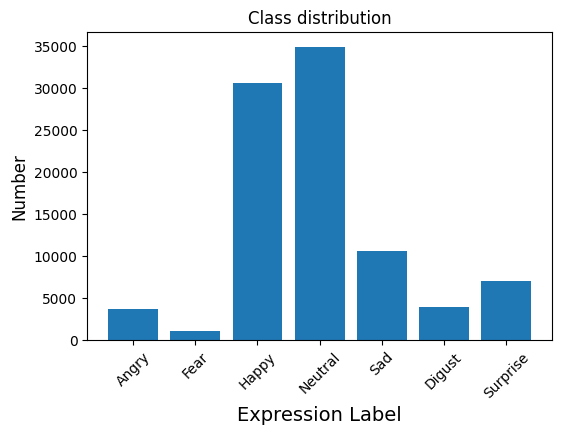

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

emotion_counts = pd.DataFrame(emotion_counts, columns=["expression_label","number"])
plt.figure(figsize=(6, 4))
plt.bar(emotion_counts.expression_label, emotion_counts.number)
plt.title('Class distribution')
plt.xlabel('Expression Label', fontsize=14)
plt.ylabel('Number', fontsize=12)
plt.xticks(rotation=45)# To rotate the x-axis labels for better visibility
plt.show()

In [ ]:
df_info.value_counts()

image_name                  face_id_in_image  face_box_top  face_box_left  face_box_right  face_box_bottom  face_box_cofidence  expression_label
awe_teacher_108.jpg         1                 600           1524           1572            648              72.4882             3                   37
astound_expression_400.jpg  3                 288           308            388             368              72.5160             3                   16
awe_student_400.jpg         2                 664           388            436             712              82.8833             6                   13
amazed_chinese_563.jpg      3                 652           1908           1956            700              56.7663             6                   12
                            1                 176           576            624             224              57.5098             6                   12
                                                                                                    

In [ ]:
df_sel=df_info[df_info.face_box_cofidence >80]
#print(df_sel)
len(df_sel)

12127

In [ ]:
df_sel.shape

(12127, 8)

In [ ]:
df_sel.columns

Index(['image_name', 'face_id_in_image', 'face_box_top', 'face_box_left',
       'face_box_right', 'face_box_bottom', 'face_box_cofidence',
       'expression_label'],
      dtype='object')

In [ ]:
df_sel.image_name

3                    angry_actor_13.jpg
4                   angry_actor_132.jpg
5                   angry_actor_137.jpg
9                   angry_actor_150.jpg
12                  angry_actor_161.jpg
                      ...              
91778       surprised_expression_37.jpg
91780      surprised_expression_289.jpg
91787    expressionless_husband_673.jpg
91789      surprised_expression_381.jpg
91790      surprised_expression_395.jpg
Name: image_name, Length: 12127, dtype: object

In [ ]:
import cv2
import os
import concurrent.futures

x = []
y = []

def process_image(row):
    img_name = row["image_name"]
    x1 = row["face_box_left"]
    y1 = row["face_box_top"]
    x2 = row["face_box_right"]
    y2 = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(images_folder_path, img_name)

    image = cv2.imread(img_path)
    if image is not None:
        cropped = image[y1:y2, x1:x2]
    else:
        return None, None
    if cropped is not None:
        resized_face = cv2.resize(cropped, (64, 64))
    else:
        return None, None
    return resized_face, label

# Function to process images in parallel
def process_images_in_parallel(dataframe):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_row = {executor.submit(process_image, row): row for i, row in dataframe.sample(10000).iterrows()}
        for future in concurrent.futures.as_completed(future_to_row):
            row = future_to_row[future]
            resized_face, label = future.result()
            if resized_face is not None:
                x.append(resized_face)
                y.append(label)




In [ ]:
# Call the function to process images in parallel
process_images_in_parallel(df_sel)

In [ ]:
print(x)
print(y)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:

len(x)

10000

In [ ]:
#Data preparation
import numpy as np
X= np.array(x)
y= np.array(y)
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:
# Step 1: Normalization
X_normalized = X / 255.0

In [ ]:
# Step 2: Sampling (optional)
sample_size = 3000
random_indices = np.random.choice(len(X_normalized), size=sample_size )
X_sampled = X_normalized[random_indices]
Y_sampled = y[random_indices]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Step 3: Encoding (for classification task)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_sampled)

In [ ]:
# Step 4: Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Step 5: Load and Fine-tune VGG16 Model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Freeze the layers so that they are not updated during training
for layer in vgg16.layers:
  layer.trainable = False


In [ ]:
# Add custom layers on top of VGG16 for classification
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

In [ ]:
# Create the model
model = Model(inputs=vgg16.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))


Epoch 1/10
75/75 [==============================] - 151s 2s/step - loss: 1.3774 - accuracy: 0.5050 - val_loss: 1.2841 - val_accuracy: 0.5533
Epoch 2/10
75/75 [==============================] - 157s 2s/step - loss: 1.1648 - accuracy: 0.5904 - val_loss: 1.2599 - val_accuracy: 0.5167
Epoch 3/10
75/75 [==============================] - 155s 2s/step - loss: 1.0283 - accuracy: 0.6237 - val_loss: 1.2150 - val_accuracy: 0.5867
Epoch 4/10
75/75 [==============================] - 157s 2s/step - loss: 0.9109 - accuracy: 0.6792 - val_loss: 1.2208 - val_accuracy: 0.5733
Epoch 5/10
75/75 [==============================] - 153s 2s/step - loss: 0.7891 - accuracy: 0.7304 - val_loss: 1.1649 - val_accuracy: 0.6017
Epoch 6/10
75/75 [==============================] - 153s 2s/step - loss: 0.6691 - accuracy: 0.7750 - val_loss: 1.3085 - val_accuracy: 0.6183
Epoch 7/10
75/75 [==============================] - 151s 2s/step - loss: 0.6031 - accuracy: 0.7950 - val_loss: 1.3040 - val_accuracy: 0.5783
Epoch 8/10
75

In [ ]:
# Calculate accuracy on test data
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32)
print(f"Test accuracy: {accuracy:.2f}")


19/19 [==============================] - 30s 2s/step - loss: 1.5528 - accuracy: 0.6300
Test accuracy: 0.63


In [ ]:
import matplotlib.pyplot as plt
# Train the model and store training history
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))


Epoch 1/10
75/75 [==============================] - 157s 2s/step - loss: 0.2446 - accuracy: 0.9246 - val_loss: 1.5546 - val_accuracy: 0.6350
Epoch 2/10
75/75 [==============================] - 158s 2s/step - loss: 0.1886 - accuracy: 0.9458 - val_loss: 1.5818 - val_accuracy: 0.6533
Epoch 3/10
75/75 [==============================] - 162s 2s/step - loss: 0.1446 - accuracy: 0.9563 - val_loss: 1.6788 - val_accuracy: 0.6083
Epoch 4/10
75/75 [==============================] - 156s 2s/step - loss: 0.1193 - accuracy: 0.9688 - val_loss: 1.6811 - val_accuracy: 0.6267
Epoch 5/10
75/75 [==============================] - 154s 2s/step - loss: 0.0619 - accuracy: 0.9908 - val_loss: 1.8024 - val_accuracy: 0.6600
Epoch 6/10
75/75 [==============================] - 154s 2s/step - loss: 0.0331 - accuracy: 0.9971 - val_loss: 1.9171 - val_accuracy: 0.6367
Epoch 7/10
75/75 [==============================] - 156s 2s/step - loss: 0.0302 - accuracy: 0.9979 - val_loss: 2.1158 - val_accuracy: 0.6367
Epoch 8/10
75

In [ ]:
# Get training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


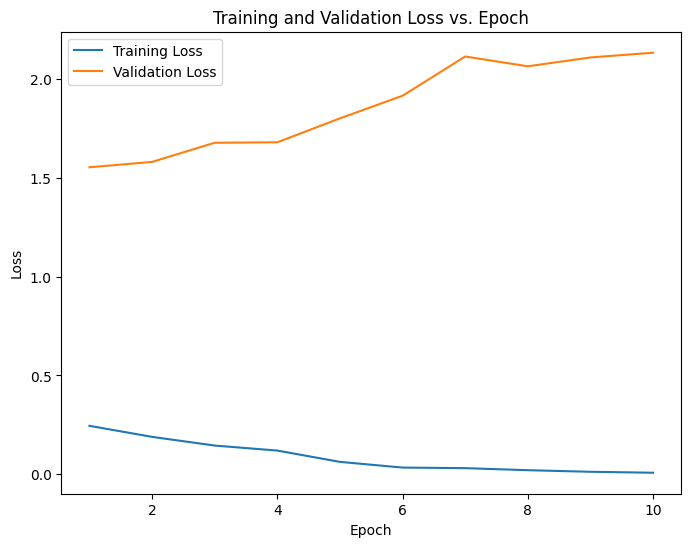

In [ ]:
# Plot the Loss vs. Epoch graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.show()


In [ ]:
# Plot the Accuracy vs. Epoch graph
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

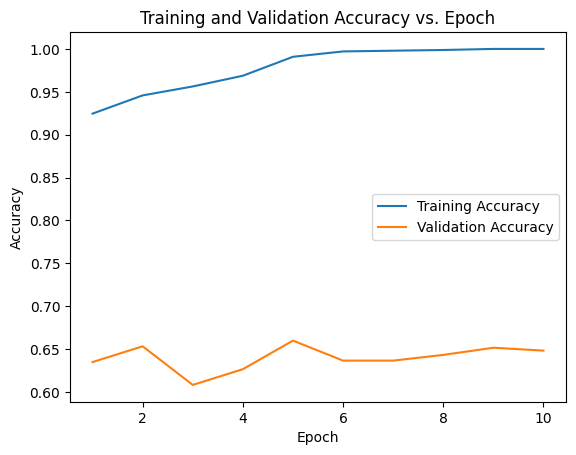

In [ ]:
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.show()

In [ ]:
# After training the model and getting good results
model.save('/content/drive/MyDrive/Colab Notebooks/emotion_model.h5')


1/1 [==============================] - 0s 378ms/step
Predicted Emotion: 3 (Happy)


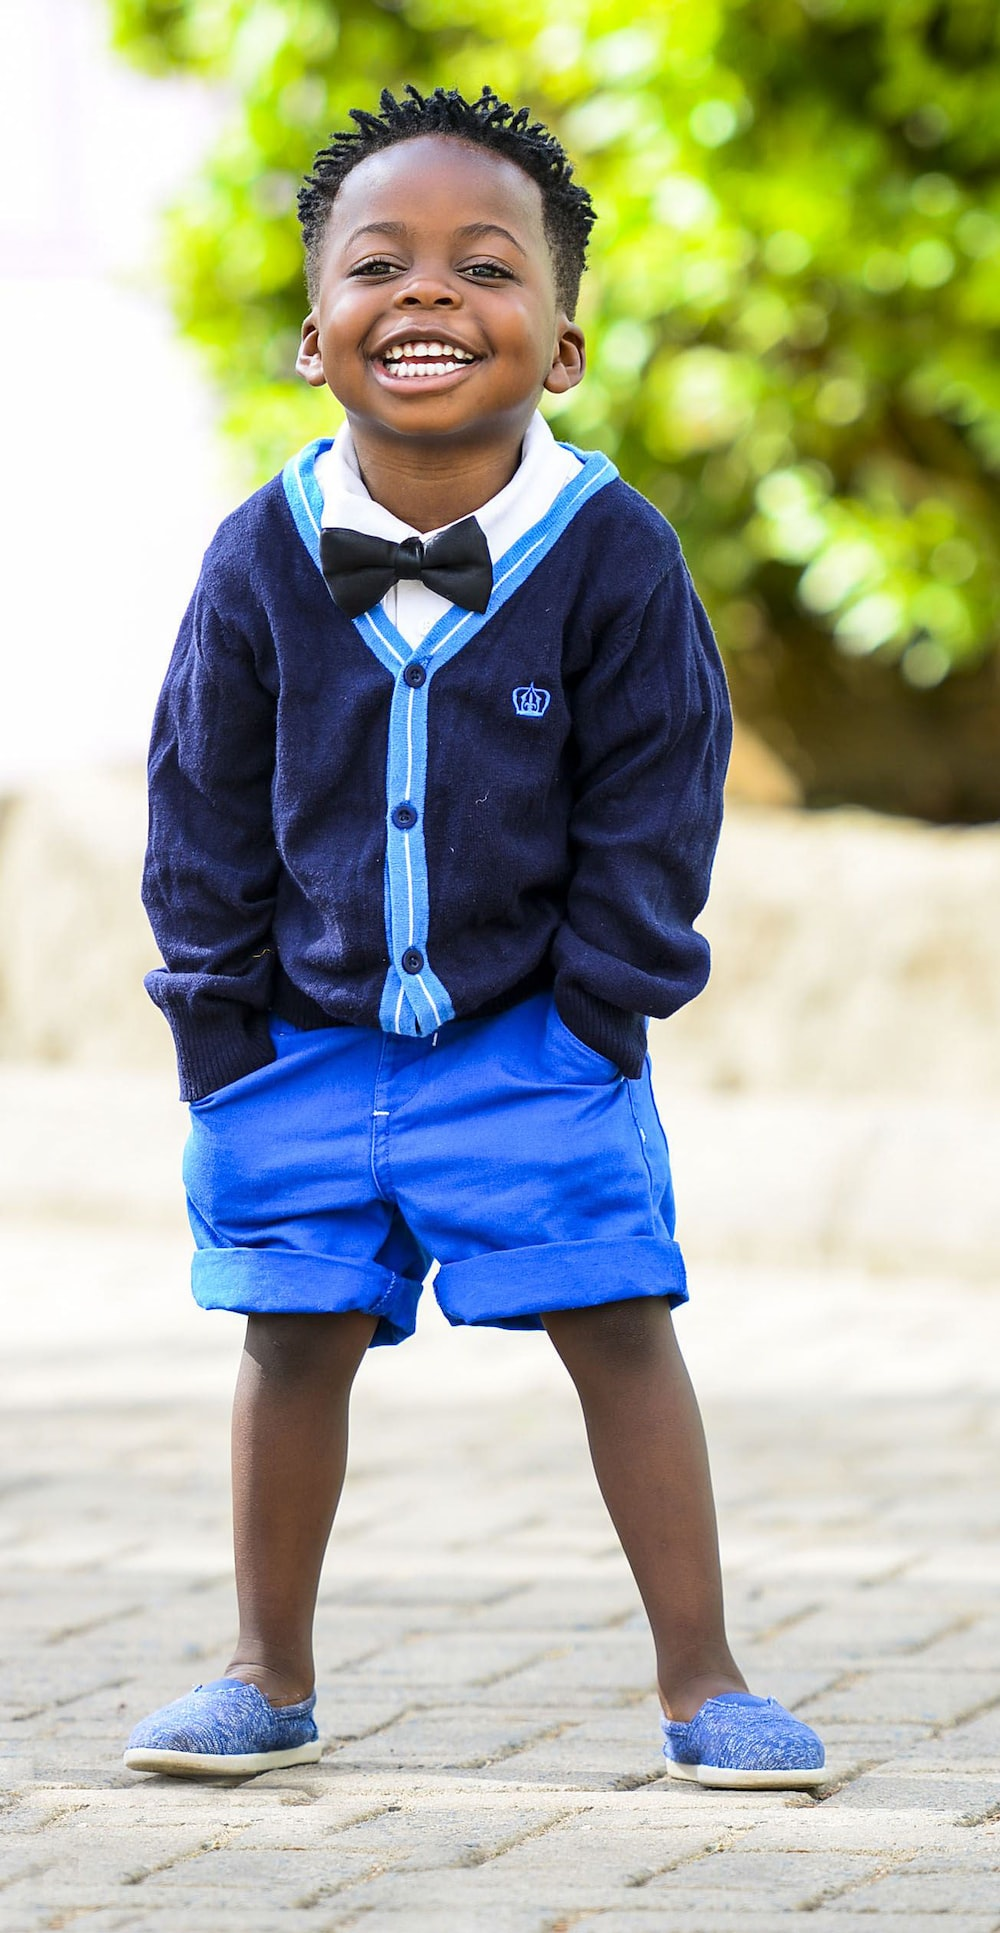

Predicted Emotion: 3 (Happy)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
# Load the trained model
model = load_model('/content/drive/MyDrive/Colab Notebooks/emotion_model.h5')


# Load and preprocess the new image
new_image_path = '/content/drive/MyDrive/Colab Notebooks/check-image.jpeg'
new_image = cv2.imread(new_image_path)
new_image = cv2.resize(new_image, (64, 64))
new_image = new_image / 255.0
new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension

# Make predictions
predicted_probabilities = model.predict(new_image)

# Decode predictions
predicted_label_index = np.argmax(predicted_probabilities)
predicted_emotion = label_encoder.inverse_transform([predicted_label_index])[0]

# Display results
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print(f'Predicted Emotion: {predicted_emotion} ({emotion_labels[predicted_label_index]})')

# Display the new image with the predicted label
from IPython.display import display, Image

# Display the new image with the predicted label
display(Image(filename=new_image_path))
print(f'Predicted Emotion: {predicted_emotion} ({emotion_labels[predicted_label_index]})')

